Load sample areas with features from file.

In [9]:
import numpy as np
import nfhelpers as nf
import sklearn as sk

sampleAreas_training = np.load("numpy_objects/training_data_set_with_features.npy")
sampleAreas_testing = np.load("numpy_objects/testing_data_set_with_features.npy")

Split data into feature values - labels

In [10]:
# Extract an array with all features
X_train = np.array(list(map(lambda s: [s.features[key] for key in [*s.features]], sampleAreas_training)))
X_test = np.array(list(map(lambda s: [s.features[key] for key in [*s.features]], sampleAreas_testing)))

# Extract all sample areas and convert to binary (25 = True, 27 = False)
y_train = np.array(list(map(lambda s: 1 if s.classification == 25 else 0, sampleAreas_training)))
y_test = np.array(list(map(lambda s: 1 if s.classification == 25 else 0, sampleAreas_testing)))

General settings

In [11]:
n_threads = 16

---------------
Train model and perform test.

In [12]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, cohen_kappa_score, roc_auc_score, average_precision_score, f1_score
import tqdm
import multiprocessing.dummy as mp


metrics = {}

clf = RandomForestClassifier(n_estimators=198, min_samples_split=22)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

importances = np.array(clf.feature_importances_)
confusion_matrix = confusion_matrix(y_test,y_pred)
metrics["accuracy"] = accuracy_score(y_test,y_pred)
metrics["recall"] = recall_score(y_test,y_pred)
metrics["kappa"] = cohen_kappa_score(y_test,y_pred)
metrics["AUROC"] = roc_auc_score(y_test,y_pred)
metrics["average_percision"] = average_precision_score(y_test,y_pred)
metrics["f_measure"] = f1_score(y_test, y_pred)

---------------
Print results from above calculations.

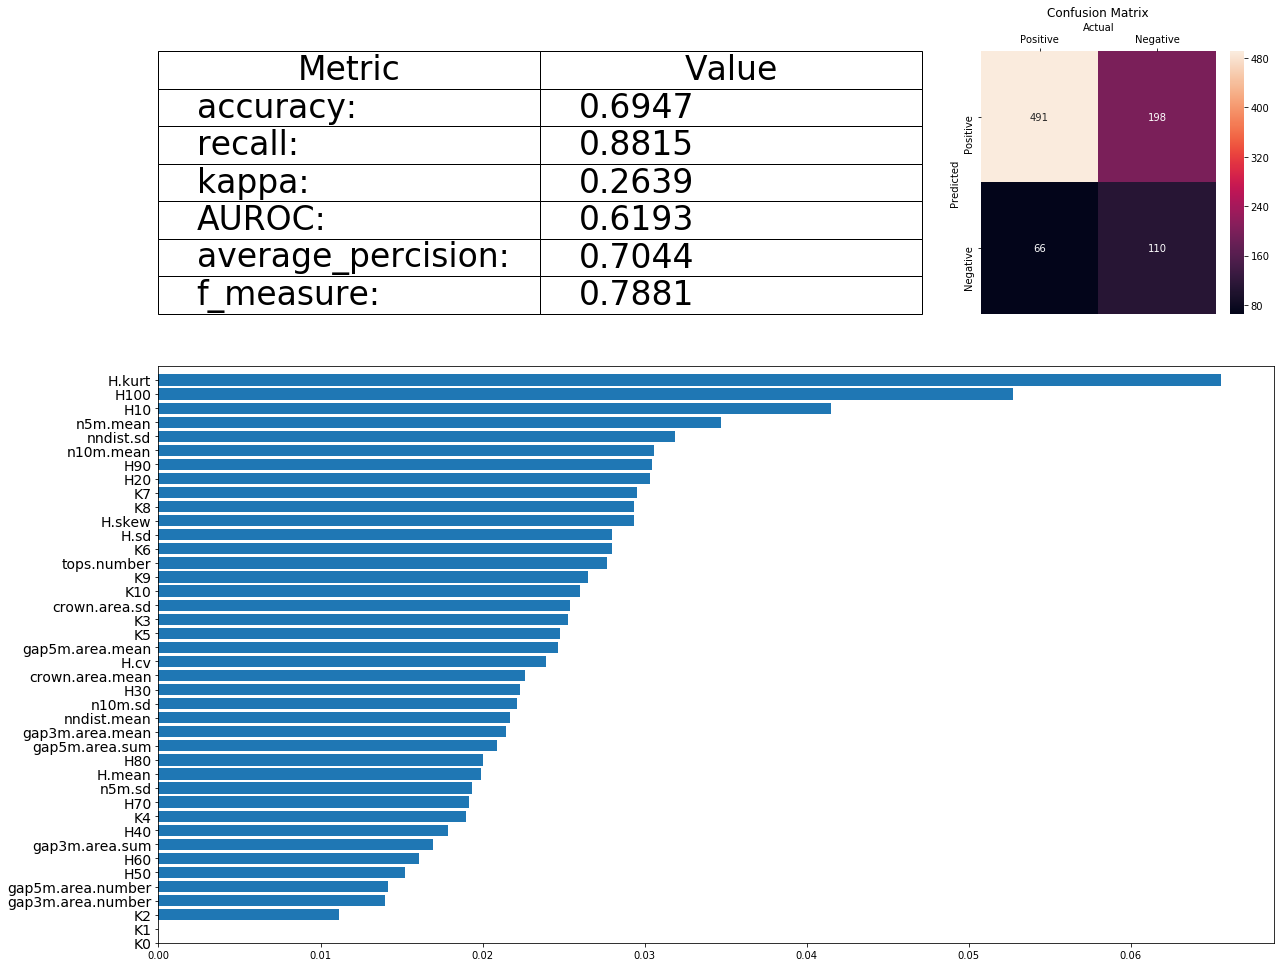

In [13]:
from matplotlib import transforms
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import datetime

df = pd.DataFrame(data={
    "Metric": list(map(lambda metric_name: f"{metric_name}:", [*metrics])),
    "Value": list(map(lambda metric_name: str(metrics[metric_name])[:6], [*metrics]))
})

n_features = len([*sampleAreas_testing[0].features])

# Setup two graphs/diagrams
fig = plt.figure()
gs = GridSpec( 1+int(0.06*n_features), 10)
fig.set_size_inches(20, 0.4*n_features)
gs.update(wspace=1)

ax1 = fig.add_subplot(gs[0,:-3])
ax2 = fig.add_subplot(gs[0,-3:])
ax3 = fig.add_subplot(gs[1:,:])

# Info
# ax1.text(0,0,"hej")
# metric_dataframe.plot(ax = ax1)
table = ax1.table(cellText=df.values, cellLoc='left', colLabels=df.columns, loc='center', bbox=[0,0,1,1])
table.set_fontsize(40)
ax1.axis("off")   

# Confusion Matrix
formatted_confusion_matrix = np.matrix(confusion_matrix[::-1]).transpose()[::-1]
sns.heatmap(formatted_confusion_matrix, annot=True, fmt='g', ax = ax2) #annot=True to annotate cells
# labels, title and ticks
ax2.set_xlabel('Actual')
ax2.xaxis.set_label_position("top")
ax2.set_ylabel('Predicted')
ax2.set_title('Confusion Matrix')
ax2.xaxis.set_ticklabels(['Positive', 'Negative'])
ax2.yaxis.set_ticklabels(['Positive', 'Negative'])
ax2.xaxis.tick_top()

# Bar graph
importances_with_labels = list(map(lambda index: ([*sampleAreas_testing[0].features][index], importances[index]), range(len(importances))))
importances_with_labels_sorted = sorted(importances_with_labels, key=lambda x: x[1])
labels = list(map(lambda x: x[0], importances_with_labels_sorted))
data = list(map(lambda x: x[1], importances_with_labels_sorted))
bars = ax3.barh(labels, data)
plt.ylim([0, n_features])

ticks = ax3.get_yticklabels()
for tick in ticks:
    tick.set_fontsize(14)

plt.savefig(f"output/{datetime.datetime.now().strftime('%Y-%m-%d %H.%M')}.pdf", bbox_inches = "tight")

In [15]:
import pickle

np.save("numpy_objects/experiment_1_metrics.npy", metrics)
np.save("numpy_objects/experiment_1_confusion_matrix.npy", confusion_matrix)
np.save("numpy_objects/experiment_1_importances.npy", importances_with_labels_sorted)

with open('numpy_objects/experiment_1_classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)